## 피마 인디언 당뇨병 예측
- pregnancies : 임신 횟수
- glucose : 포도당 부하 검사 수치
- bloodpressure : 혈압
- skinthickness : 팔 삼두근 뒤쪽의 피하지방 측정값
- insulin : 혈청 인슐린
- BMI : 체질량지수
- DiabetesPedigreeFunction : 당뇨 내력 가중치 값
- Age : 나이
- Outcome : 클래스 결정 값

[분석 과정]

데이터 살펴보기 -> 데이터 전처리 -> 데이터 변환과 스케일링을 통한 성능 향상 -> 임곗값 변화를 통한 재현율 향상

[정리]

**분류**

1. 정확도
- 이진 분류의 레이블 분포가 불균형할 경우 단순히 정확도만으로는 머신러닝 성능 예측이 어려움

2. 오차 행렬
- 분류 모델 예측 성능의 오류가 어떻게 발생하는지 알 수 있음

3. 정밀도와 재현율
- positive 데이터 세트의 예측 성능에 초점을 맞춘 평가 지표.
- 업무 특성상 정밀도 혹은 재현율을 강조해야 하는 경우 분류의 결정 임곗값을 조절해 정밀도/재현율 수치를 높일 수 있음

4. F1 score
- 정밀도와 재현율이 결합된 평가 지표. 어느 한 쪽으로 치우치지 않을 때 높은 지표값을 가짐. AUC는 ROC 곡선 하단의 면적을 구한 값으로, 1에 가까울수록 좋음

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('C:/Users/gyw78/Desktop/ewha/3-1/esaa/과제/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [5]:
# feature type과 Null 개수
diabetes_data.info()
# null 값은 없고 모두 숫자형임 -> 별도의 피처 인코딩은 필요 없어보임

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
# 로지스틱 회귀를 이용한 예측 모델 생성 (당뇨병 yes/no ; 범주형)
# 피처 데이터 세트 x, 레이블 데이터 세트 y를 추출
# 맨 끝이 outcome 칼럼으로 레이블 값. 칼럼 위치 -1 을 이용해 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state=156,
                                                    stratify=y)
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # roc_auc 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
# 로지스틱 회귀로 학습, 예측, 평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도 : 0.7727, 정밀도 : 0.7209, 재현율 : 0.5741,     F1 : 0.6392, AUC:0.7919


C:\Users\gyw78\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# 전체 데이터의 65% 가 Negative이므로 정확도 재현율 성능에 초점
# 정밀도 재현율 곡선 -> 재현율과 정밀도 값의 변화를 확인

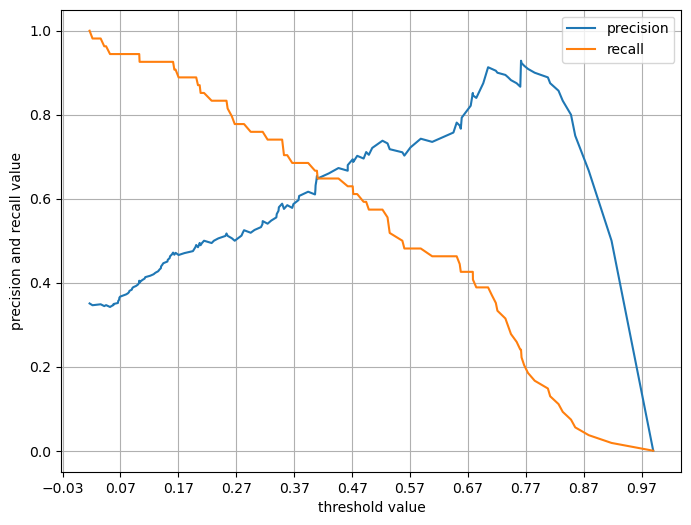

In [13]:
def precision_recall_curve_plot(y_test, pred_proba_c1) :
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율, ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, 
                                                             pred_proba_c1)
    # x축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 plot 수행, 정밀도는 점선
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 x축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('threshold value'); plt.ylabel('precision and recall value')
    plt.legend(); plt.grid()
    plt.show()
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

임곗값을 0.42 정도로 낮추면 정밀도와 재현율을 균형을 맞출 수 있음

In [14]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

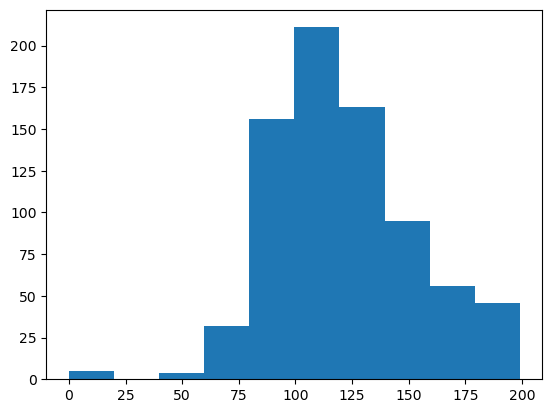

In [15]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [23]:
# 179
# 0값을 검사할 피처 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI']
# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features :
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count,
                                                100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


SkinThickness와 Insulin의 0값은 전체에서 많은 비중을 차지함. 이 값들을 일괄적으로 삭제할 경우 학습을 효과적으로 수행하기 어려우므로 다른 값으로 대체해야 함

In [24]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

데이터 세트에 피처 스케일링을 적용해 변환,
로지스틱 회귀의 경우 숫자 데이터에 스케일링을 적용하는 것이 좋음

In [27]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:,-1]

# standardscaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                   test_size=0.2,
                                                   random_state=156)
# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[83 14]
 [25 32]]
정확도 : 0.7468, 정밀도 : 0.6957, 재현율 : 0.5614,     F1 : 0.6214, AUC:0.8320


데이터 변환과 스케일링으로 성능 수치가 개선되었지만 재현율 수치는 개선이 필요해보임. 분류 결정 임곗값의 변환을 통해 재현율 값 수치 개선

In [43]:
# 181
from sklearn.preprocessing import Binarizer
def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # f1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 스코어 print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, f1 : {3:.4f}'.format(accuracy, precision, recall, f1))
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds) :
    # thresholds list 객체 내 값을 차례로 반복하며 평가 수행
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)


임곗값 0.3
오차 행렬
[[73 24]
 [16 41]]
정확도 : 0.7403, 정밀도 : 0.6308, 재현율 : 0.7193, f1 : 0.6721
임곗값 0.33
오차 행렬
[[75 22]
 [17 40]]
정확도 : 0.7468, 정밀도 : 0.6452, 재현율 : 0.7018, f1 : 0.6723
임곗값 0.36
오차 행렬
[[75 22]
 [20 37]]
정확도 : 0.7273, 정밀도 : 0.6271, 재현율 : 0.6491, f1 : 0.6379
임곗값 0.39
오차 행렬
[[79 18]
 [21 36]]
정확도 : 0.7468, 정밀도 : 0.6667, 재현율 : 0.6316, f1 : 0.6486
임곗값 0.42
오차 행렬
[[79 18]
 [23 34]]
정확도 : 0.7338, 정밀도 : 0.6538, 재현율 : 0.5965, f1 : 0.6239
임곗값 0.45
오차 행렬
[[81 16]
 [25 32]]
정확도 : 0.7338, 정밀도 : 0.6667, 재현율 : 0.5614, f1 : 0.6095
임곗값 0.48
오차 행렬
[[83 14]
 [25 32]]
정확도 : 0.7468, 정밀도 : 0.6957, 재현율 : 0.5614, f1 : 0.6214
임곗값 0.5
오차 행렬
[[83 14]
 [25 32]]
정확도 : 0.7468, 정밀도 : 0.6957, 재현율 : 0.5614, f1 : 0.6214


정밀도/정확도를 희생하고 재현율을 높이는 가장 좋은 임곗값은 0.33, 그러나 정밀도가 매우 저조해졌으므로 극단적 선택. 0.48을 임곗값으로 설정하는 것이 적절해 보임

In [39]:
# 임곗값을 0.48로 설정한 binarizer 설정
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba()예측 확률 array에서 1에 해당 칼럼값을 binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[83 14]
 [25 32]]
정확도 : 0.7468, 정밀도 : 0.6957, 재현율 : 0.5614,     F1 : 0.6214, AUC:0.8320
